# Thomas Wildfire Perimeter and Air Quality Index
Hwk 2-Task 2: Air Quality Index Data + Hwk4-Task 2: False color image

Author: Vanessa Salgado

Link to GitHub repository: https://github.com/Vanessa-Salgado/eds220-hw4-task3

## Purpose
The Thomas Fires was a massife wildfire that affected Ventura and Santa Barbara counties in December 2017. 
The Thomas Fire destroyed at least 1,063 structures, while damaging 280 others; and the fire caused over $2.2 billion (2018 USD) in damages. As of August 2020, the Thomas Fire is California's tenth-most destructive wildfire. In this notebook we analyze the Air Quality Index that occured the time leading up to and after the Thomas Fire. We will create a map of the Thomas Fire perimeter to visualize the damage using `landsat 8` imagery 

### Highlights

* Data wrangling and exploration of with pandas
* Geospatial data wrangling with geopandas
* Merging of tabular and vector data
* Creating and customizing raster map 

### Dataset Description

In this notebook we use N datasets: 

**1) US EPA Air Quality Index(AQI)**

The US Environmentla Protection Agency air quality collects data from outdoor monitors across the United States, Puerto Rico, and the U.S Virgin Islands. The data comes primarily from the AQS (Air Quality System) database.

This data set was downloaded from the EPA AirData portal. The data was available from the Pre-Generate Data Files that collects daily AQI readings by county per year [https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI]. The files are updated twice per year: once in June to capture the complete data for the prior year and once in December to capture the data for the summer (ozone season). For this analysis we collect the will use the following columns of interest: 

* date: 
* county Name: 
* Date: 
* AQI: 
* 

We specifically look at 2017 and 2018 in order to study the before and after affects of the Thomas Fire

Access here: 

**2)Landsat 8 Surface Reflectance Satellite Data**

A simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite.

The data was accessed and pre-processed in the Microsoft Planetary Computer to remove data outside land and coarsen the spatial resolution (Landsat Collection in MPC). Data should be used for visualization purposes only.

Access here: 

**3) 

A shapefile of fire perimeters in California during 2017. The state of California contains geospatial data of  California's Fire Wildfire Perimeters and Prescribed Burns hosted on the CAL FIRE AGeoportal. You can access it here: 

## Final Output


In [ ]:
# TBD

## Data Exploration

#### Import Libraries and functions:  

In [1]:
#import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
import rioxarray as rioxr
import geopandas as gpd
from rasterio.features import rasterize

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


#### Import Data
Import 2017 and 2018 aqi data 

In [2]:

# read in data from 2017 URL 
aqi_17 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip") 
# read in data from 2017 URL 
aqi_18 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip')

#### Prepare Data



In [3]:
# combine 2017 and 2018 into a single df using concatenation
aqi = pd.concat([aqi_17, aqi_18])
# 

Clean and make datatypes of columns appropaite to perform arithmetic functions: 

In [4]:
# combine 2017 and 2018 into a single df using concatenation
aqi = pd.concat([aqi_17, aqi_18])

#clean the column names, removing spaces and turning all strings to lowercase
aqi.columns = aqi.columns.str.lower().str.replace(' ','_') #code provided

# create subset of SB County w/desired columns
aqi_sb = aqi.loc[aqi['county_name']=='Santa Barbara', #row-selection
       ['date','aqi','category','defining_parameter', 'defining_site','number_of_sites_reporting']] #column-selection

# change date column to object type = datatime
aqi_sb.date = pd.to_datetime(aqi_sb.date)

In [5]:
aqi_sb.shape

(730, 6)

In [6]:
aqi_sb[aqi] - aq

,date,aqi,category,defining_parameter,defining_site,number_of_sites_reporting
28648,2017-01-01,39,Good,Ozone,06-083-4003,12
28649,2017-01-02,36,Good,Ozone,06-083-4003,11
28650,2017-01-03,71,Moderate,PM10,06-083-4003,12
28651,2017-01-04,34,Good,Ozone,06-083-4003,13
28652,2017-01-05,37,Good,Ozone,06-083-4003,12
...,...,...,...,...,...,...
29128,2018-12-27,37,Good,Ozone,06-083-1025,11
29129,2018-12-28,39,Good,Ozone,06-083-1021,12
29130,2018-12-29,39,Good,Ozone,06-083-1021,12
29131,2018-12-30,39,Good,Ozone,06-083-1021,12


## Analysis
Analysis
- Include subsections as necessary to guide reader through your analysis
- Include checks to see operations worked
- Checks must be short and informative: print specific attributes

Inspecting the the daily AQI of Santa Barbara County would introduce a lot of noise into the analysis. A rolling 5 day average would seem like an appropiate modification to analyzing daily AQI readings. 

Here we will compute the 5 day rolling average

In [7]:
# set date column as the index
aqi_sb = aqi_sb.set_index('date')

In [20]:
aqi_sb['aqi_difference'] = aqi_sb_subset['aqi'] - aqi_sb['five_day_average']

####  Context
It is important to show the average along with the true value of AQI to visually see if the computation and the data make intuitive sense. 

Here I will check what the change from the true value and the rolling . First Check if dimensions of `aqi_sb_subset` is the same as `aqi_sb` that been modified with the 5 day average.

Here I attempted to find the residual of the daily aqi reading and the 5 day rollling average. 

In [ ]:
aqi_sb['aqi_difference'] = aqi_sb_subset['aqi'] - aqi_sb['five_day_average']

In [24]:
max(aqi_sb['aqi_difference'])

181.8

In [25]:
min(aqi_sb['aqi_difference'])

-62.599999999999994

<bound method Series.unique of date
2017-01-01     0.000000
2017-01-02    -1.500000
2017-01-03    22.333333
2017-01-04   -11.000000
2017-01-05    -6.400000
                ...    
2018-12-27    -1.600000
2018-12-28     0.400000
2018-12-29     0.800000
2018-12-30     1.200000
2018-12-31    -0.400000
Name: aqi_difference, Length: 730, dtype: float64>

#### Visualization 
The purpose of this visualization is toshow both the daily AQI and the 5-day average from 2017 to 2018. 

<Axes: title={'center': 'Santa Barbara Air Quality 2017-18'}, xlabel='date'>

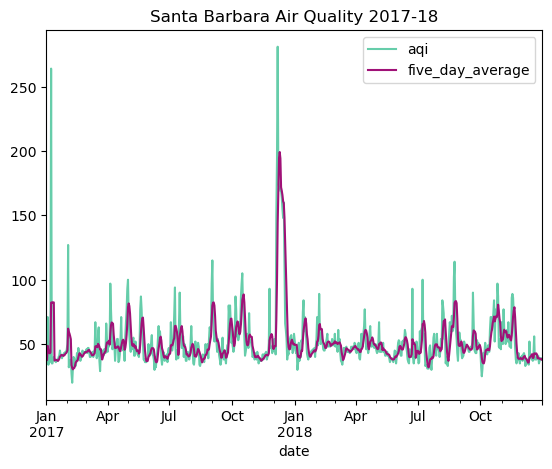

In [28]:
#### Visualization 

aqi_sb.aqi.plot(color = '#66CDAA', legend = True) 

aqi_sb.five_day_average.plot(color = '#A01177', 
                            title = 'Santa Barbara Air Quality 2017-18',
                            legend = True)

We can see the the AQI going up during the Thomas Fire in December 2017. There is a visible spike on December 2017. AQI is over 250 and nearly reaching 300 AQI index. Anything between 201 to 300 is very unhealthy and anything over 300 is deemed hazardous according to the EPA’s index. 

## Landsat 8 false color image

In [ ]:
###  Data Exploration


####  Fetch Raster Data 

In [29]:
# load the nc data
data_path = os.path.join(os.getcwd(), "data/landsat8-2018-01-26-sb-simplified.nc")
landsat = rioxr.open_rasterio(data_path)

RasterioIOError: /Users/vanessa/Documents/MEDSFALL23/EDS220/homework/eds220-hw4-task3/data/landsat8-2018-01-26-sb-simplified.nc: No such file or directory

Raster Exploratory Plot of Data Variables

In [ ]:
# exploration of landsat raster

#exploratory plot

fig, axs = plt.subplots(2, 2)

landsat.red.plot(ax = axs[0, 0])
axs[0, 0].set_title('Red')
landsat.green.plot(ax = axs[0, 1])
axs[0, 1].set_title('Green')
landsat.blue.plot(ax = axs[1, 0])
axs[1, 0].set_title('Blue')
landsat.swir22.plot(ax = axs[1, 1])
axs[1, 1].set_title('swir22')

In [ ]:
# check the raster's CRS
landsat.rio.crs

###  Prepare Data
